In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import drive
import json
from tqdm.notebook import tqdm
from itertools import product

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset_hackaton_2024.zip -d /content/data/

Archive:  /content/drive/MyDrive/dataset_hackaton_2024.zip
   creating: /content/data/dataset_hackaton_2024/test/
   creating: /content/data/dataset_hackaton_2024/test/inappropriate/
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/_Aj2vHGWN4A.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/6m-Cbw1J9G4.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/CkhREf7earc.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/d92ylc627TI.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/FHQjn72ziBo.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/HFA65Z2-k_I.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/i91-4Ax8KuA.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/kypeY1St5ec.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/mAYDf_EpUao.jpg  
  inflating: /content/data/dataset_hackaton

## Defining contstants

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
CLASS_NAMES = {
    'safe': [0, 1],
    'inappropriate': [1, 0]
}

DATA_ROOT = '/content/data/dataset_hackaton_2024'

## Define the model

In [ ]:
vgg19 = torchvision.models.vgg19(torchvision.models.VGG19_Weights.IMAGENET1K_V1)
# redefine the classifier
params_list = [nn.Linear(25088, 4096, bias=True),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(4096),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 4096, bias=True),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(4096),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 1000, bias=True),
                           nn.BatchNorm1d(1000),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.5),
                           nn.Linear(1000, 2, bias=True)]
class Model(nn.Module):
    def __init__(self, params, freeze: bool, vgg):
        super().__init__()
        self.extractor = vgg.features
        for param in self.extractor.parameters():
            param.requires_grad = not freeze
        self.flatten = nn.Flatten(1, 3)
        self.BN = nn.BatchNorm1d(25088)
        self.classifier = nn.Sequential(*params)
    def forward(self, x):
        features = self.extractor(x)
        flattened = self.flatten(features)
        classes = self.classifier(self.BN(flattened))
        return torch.nn.functional.softmax(classes)


model = Model(params_list, True, vgg19)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


#### Augments and utility functoins

In [ ]:
preprocessors = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) # inference time

augments = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.2)),
    transforms.RandomRotation(15),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) #train time


In [ ]:
def show_image(img):
  if isinstance(img, torch.Tensor):
      plt.imshow(img.view(-1, IMAGE_SIZE, IMAGE_SIZE).permute(1,
                  2, 0).detach().cpu().numpy())
  elif isinstance(img, str):
      img = Image.open(img)
      plt.imshow(img)
  else:
      plt.imshow(img)
  plt.show()

In [ ]:
# img_tensor = preprocessors(Image.open('../image.png'))
# show_image(img_tensor)
# model(img_tensor) # try to infer the model

#### Define dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transform, mode) -> None:
        self.mode = mode
        self.transforms = transform
        self.files = list()
        self.labels = list()
        image_set_name = 'train'
        if self.mode == 'test':
            image_set_name = 'test'
        if self.mode == 'valid':
            image_set_name = 'valid'

        dir = os.path.join(root, image_set_name)
        for class_dir in os.listdir(dir):
            path_to_all_calss_files = os.path.join(dir, class_dir)
            for filename in os.listdir(path_to_all_calss_files):
                full_path = os.path.join(path_to_all_calss_files, filename)
                if os.path.isfile(full_path):
                    self.files.append(full_path)
                    self.labels.append(CLASS_NAMES[class_dir.lower()])

        assert len(self.labels) == len(
            self.files), "each file should have a label"

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img = self.transforms(img)
        labels = self.labels[index % len(self.labels)]

        return (img, torch.tensor(labels, dtype=torch.float32))

    def __len__(self):
        return len(self.files)

In [ ]:
def plot_history(history, title:str):
    plt.figure(figsize=(12, 8))
    epochs = len(history['train'])
    plt.plot(range(epochs), history['train'], label = 'train')
    plt.plot(range(epochs), history['val'], label = 'val')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
train_dataset = ImageDataset(DATA_ROOT, augments, 'train')
valid_dataset = ImageDataset(DATA_ROOT, preprocessors, 'valid')
test_dataset = ImageDataset(DATA_ROOT, preprocessors, 'test')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
mse_loss = nn.MSELoss()
bce_loss = nn.CrossEntropyLoss()

In [ ]:
def train(model, epochs, loss_function, frozen,  lr):
    best_val_loss = float('inf')
    template = '[{:3}/{:3}]\ttrain loss: {:2.3f}\tval loss: {:2.3f}'
    history = {'train':list(), 'val':list()}
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_train, epoch_val = 0, 0
        for batch in train_dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            # print([x.item() for x in preds])
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()

            epoch_train+=loss
        epoch_train /= len(train_dataloader)
        history['train'].append(epoch_train.item())

        model.eval()
        for batch in valid_dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                preds = model(images)
                # print(preds)
                # show_image(images[0])
                loss = loss_function(preds, labels)

            epoch_val+=loss
        epoch_val /= len(valid_dataloader)
        history['val'].append(epoch_val.item())
        if(epoch_val<=best_val_loss):
            best_val_loss = epoch_val
            arg1 = "frozen" if frozen else "unfreezed"
            arg2 = "MSE" if isinstance(loss_function, torch.nn.modules.loss.MSELoss) else "CrossEntropy"
            torch.save(model.state_dict(), f'/content/{arg1}_{arg2}_lr{lr}_best.pt')
        print(template.format(epoch+1, epochs, epoch_train, epoch_val))
    return history

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

<ipython-input-253-4a4034149a2e>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(classes)


[  1/ 25]	train loss: 0.305	val loss: 0.325
[  2/ 25]	train loss: 0.338	val loss: 0.300
[  3/ 25]	train loss: 0.297	val loss: 0.175
[  4/ 25]	train loss: 0.317	val loss: 0.250
[  5/ 25]	train loss: 0.278	val loss: 0.225
[  6/ 25]	train loss: 0.310	val loss: 0.325
[  7/ 25]	train loss: 0.310	val loss: 0.325
[  8/ 25]	train loss: 0.320	val loss: 0.275
[  9/ 25]	train loss: 0.257	val loss: 0.225
[ 10/ 25]	train loss: 0.340	val loss: 0.475
[ 11/ 25]	train loss: 0.475	val loss: 0.425
[ 12/ 25]	train loss: 0.512	val loss: 0.450
[ 13/ 25]	train loss: 0.467	val loss: 0.525
[ 14/ 25]	train loss: 0.520	val loss: 0.550
[ 15/ 25]	train loss: 0.485	val loss: 0.475
[ 16/ 25]	train loss: 0.398	val loss: 0.450
[ 17/ 25]	train loss: 0.360	val loss: 0.350
[ 18/ 25]	train loss: 0.377	val loss: 0.500
[ 19/ 25]	train loss: 0.382	val loss: 0.450
[ 20/ 25]	train loss: 0.362	val loss: 0.425
[ 21/ 25]	train loss: 0.377	val loss: 0.550
[ 22/ 25]	train loss: 0.360	val loss: 0.475
[ 23/ 25]	train loss: 0.380	val 

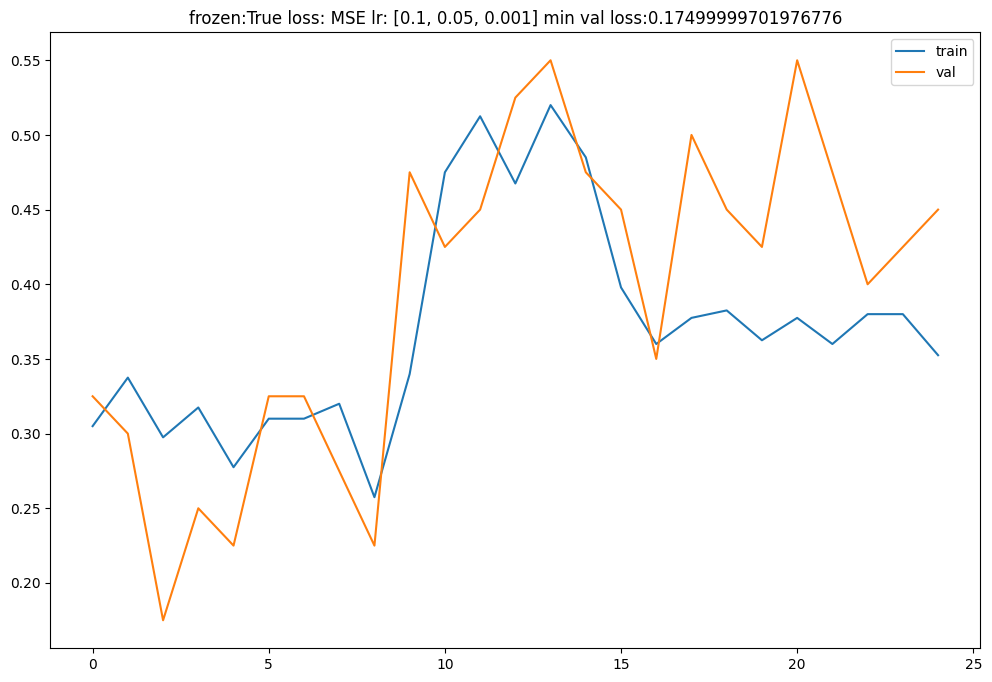

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: 0.280	val loss: 0.350
[  2/ 25]	train loss: 0.290	val loss: 0.400
[  3/ 25]	train loss: 0.295	val loss: 0.375


KeyboardInterrupt: 

In [ ]:
loss_functions = [mse_loss, bce_loss]
frozen = [True, False]
lr = [0.1, 0.05, 0.001]

temp = dict()

for lf, fr, learning_rate in product(loss_functions, frozen, lr):
    vgg19 = torchvision.models.vgg19(torchvision.models.VGG19_Weights.IMAGENET1K_V1)
    model_l = Model(params_list, fr, vgg19)
    history = train(model_l, 25, lf, fr, learning_rate)
    arg2 = "MSE" if isinstance(lf, torch.nn.modules.loss.MSELoss) else "CrossEntropy"
    min_loss = min(history["val"])
    title = f'frozen:{fr} loss: {arg2} lr: {learning_} min val loss:{min_loss}'
    temp[title] = history
    with open('results.json', 'w') as fp:
        json.dump(temp, fp)
    plot_history(history, title = title)
